# Aprendendo como mexer no Wavelet

In [42]:
from __future__ import division
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd

import pycwt as wavelet
from pycwt.helpers import find

In [43]:
dados = pd.read_excel('SN_d_tot.xlsx')
dados = dados.dropna(axis=1)
for i in range(len(dados['Daily sunspot number'])):
    if dados['Daily sunspot number'][i] == -1:
        dados['Daily sunspot number'][i] = 0
print(dados)

      Year  Month  Day  Day in fraction of year  Daily sunspot number
0     2012      1    1                 2012.001                    71
1     2012      1    2                 2012.004                    92
2     2012      1    3                 2012.007                   120
3     2012      1    4                 2012.010                   126
4     2012      1    5                 2012.012                   109
...    ...    ...  ...                      ...                   ...
3648  2021     12   27                 2021.988                   109
3649  2021     12   28                 2021.990                   102
3650  2021     12   29                 2021.993                    87
3651  2021     12   30                 2021.996                    70
3652  2021     12   31                 2021.999                    62

[3653 rows x 5 columns]


In [44]:
# Formatando o índice
indice = []
for i in range(len(dados['Year'])):
    indice.append([dados['Year'][i],dados['Month'][i]])

dadosInFraction = pd.DataFrame(dados['Day in fraction of year'], index=indice)

<AxesSubplot:title={'center':'Número de sunspot por mês'}, xlabel='Data (Ano, mês)', ylabel='Contagem de eventos'>

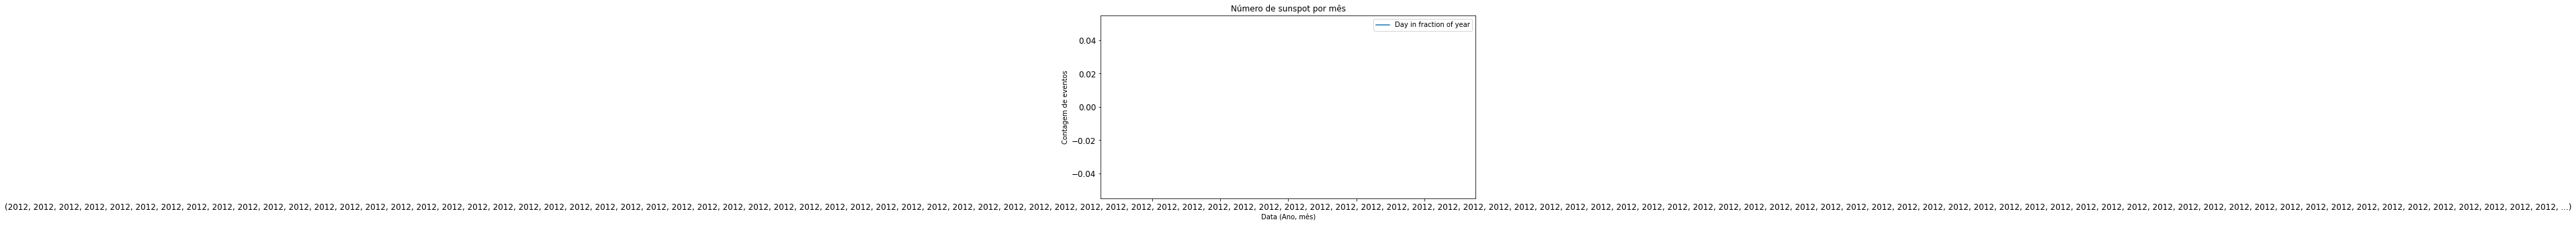

In [45]:
dadosInFraction.plot(fontsize=12, figsize=(10, 5), title='Número de sunspot por mês', xlabel='Data (Ano, mês)', ylabel='Contagem de eventos')

## Normalizando a anomalia (série já dessazonalizada).

In [46]:
# Arrumando o conjunto de valores para poder fazer a media
janeiro, fevereiro, marco, abril, maio, junho, julho, agosto, setembro, outubro, novembro, dezembro = [],[],[],[],[],[],[],[],[],[],[],[]
a = []
b = list(anomalia.values)
for x in b:
    a.append(x)

for x in range(len(anomalia.index)):
    if anomalia.index[x][1] == 1:
        janeiro.append(a[x])
    elif anomalia.index[x][1] == 2:
        fevereiro.append(a[x])
    elif anomalia.index[x][1] == 3:
        marco.append(a[x])
    elif anomalia.index[x][1] == 4:
        abril.append(a[x])
    elif anomalia.index[x][1] == 5:
        maio.append(a[x])
    elif anomalia.index[x][1] == 6:
        junho.append(a[x])
    elif anomalia.index[x][1] == 7:
        julho.append(a[x])
    elif anomalia.index[x][1] == 8:
        agosto.append(a[x])
    elif anomalia.index[x][1] == 9:
        setembro.append(a[x])
    elif anomalia.index[x][1] == 10:
        outubro.append(a[x])
    elif anomalia.index[x][1] == 11:
        novembro.append(a[x])
    else:
        dezembro.append(a[x])

NameError: name 'anomalia' is not defined

In [ ]:
# Média
jan_avg = np.mean(janeiro)
fev_avg = np.mean(fevereiro)
mar_avg = np.mean(marco)
abr_avg = np.mean(abril)
mai_avg = np.mean(maio)
jun_avg = np.mean(junho)
jul_avg = np.mean(julho)
ago_avg = np.mean(agosto)
set_avg = np.mean(setembro)
out_avg = np.mean(outubro)
nov_avg = np.mean(novembro)
dez_avg = np.mean(dezembro)

# Desvio-padrao
jan_std = np.std(janeiro)
fev_std = np.std(fevereiro)
mar_std = np.std(marco)
abr_std = np.std(abril)
mai_std = np.std(maio)
jun_std = np.std(junho)
jul_std = np.std(julho)
ago_std = np.std(agosto)
set_std = np.std(setembro)
out_std = np.std(outubro)
nov_std = np.std(novembro)
dez_std = np.std(dezembro)

print(jan_std)
print(fev_std)

0.4841229182759271
0.5


<AxesSubplot:title={'center':'Série de anomalias'}, xlabel='Data (Ano, mês)', ylabel='Contagem de anomalias'>

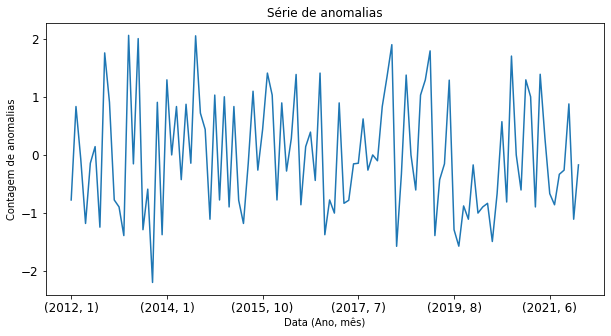

In [ ]:
contNormalizada = []
for i in range(len(cont.index)):
    mes_Normalizado = 0.0
    if cont.index[i][1] == 1:
        mes_Normalizado = (a[i] - jan_avg)/jan_std
    elif cont.index[i][1] == 2:
        mes_Normalizado = (a[i] - fev_avg)/fev_std
    elif cont.index[i][1] == 3:
        mes_Normalizado = (a[i] - mar_avg)/mar_std
    elif cont.index[i][1] == 4:
        mes_Normalizado = (a[i] - abr_avg)/abr_std
    elif cont.index[i][1] == 5:
        mes_Normalizado = (a[i] - mai_avg)/mai_std
    elif cont.index[i][1] == 6:
        mes_Normalizado = (a[i] - jun_avg)/jun_std
    elif cont.index[i][1] == 7:
        mes_Normalizado = (a[i] - jul_avg)/jul_std
    elif cont.index[i][1] == 8:
        mes_Normalizado = (a[i] - ago_avg)/ago_std
    elif cont.index[i][1] == 9:
        mes_Normalizado = (a[i] - set_avg)/set_std
    elif cont.index[i][1] == 10:
        mes_Normalizado = (a[i] - out_avg)/out_std
    elif cont.index[i][1] == 11:
        mes_Normalizado = (a[i] - nov_avg)/nov_std
    else:
        mes_Normalizado = (a[i] - dez_avg)/dez_std
    # contAvgNormalizado.append(round(mes_Normalizado))
    contNormalizada.append(mes_Normalizado)

dadosNormalizados = pd.Series(data=contNormalizada, index=cont.index)
dadosNormalizados.plot(fontsize=12, figsize=(10, 5), title='Série de anomalias', xlabel='Data (Ano, mês)', ylabel='Contagem de anomalias')

## Wavelet
### Funcao: F(x) = (x - xAvg) / (std)

In [ ]:
print(dadosNormalizados.head())

trigger_time  trigger_time
2012          1              -0.774597
              4               0.832050
              5              -0.070888
              6              -1.178326
              7              -0.142857
dtype: float64


In [ ]:
# Arrumando tabela de valores
dados = []
b = list(dadosNormalizados.values)
# b = list(anomalia.values)
for x in b:
    dados.append(x)
    
dados = pd.DataFrame(dados, columns=['dados normalizados'])
dat = dados['dados normalizados']

title = 'Número de TGF por mês'
label = 'Números de TGFs'
units = 'Unidade'

t0 = 2012.0 # Ano-Mês inicial
dt = (1)/(12) # Intervalos de 1 mês
N = dat.size
t = np.arange(0,N) * dt + t0

print(dat)

# dat -> dados normalizados
# anomalia -> dados dessazonalizados

0     -0.774597
1      0.832050
2     -0.070888
3     -1.178326
4     -0.142857
         ...   
102   -0.333333
103   -0.261488
104    0.877058
105   -1.105542
106   -0.171499
Name: dados normalizados, Length: 107, dtype: float64


In [ ]:
mother = wavelet.Morlet(6)
s0 = 1 * dt # Escala inicial
dj = 1 / 12  
J = 7 / dj 
anomalia = np.array(anomalia)
dat = np.array(dat)
alpha, _, _ = wavelet.ar1(anomalia)

In [ ]:
# Aplica transformada
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat, dt, dj, s0, J, mother)

In [ ]:
# espectro de potencia
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = (1 / freqs) 
# retifica
power /= scales[:, None]

In [ ]:
# teste de significancia do espectro de potencia
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

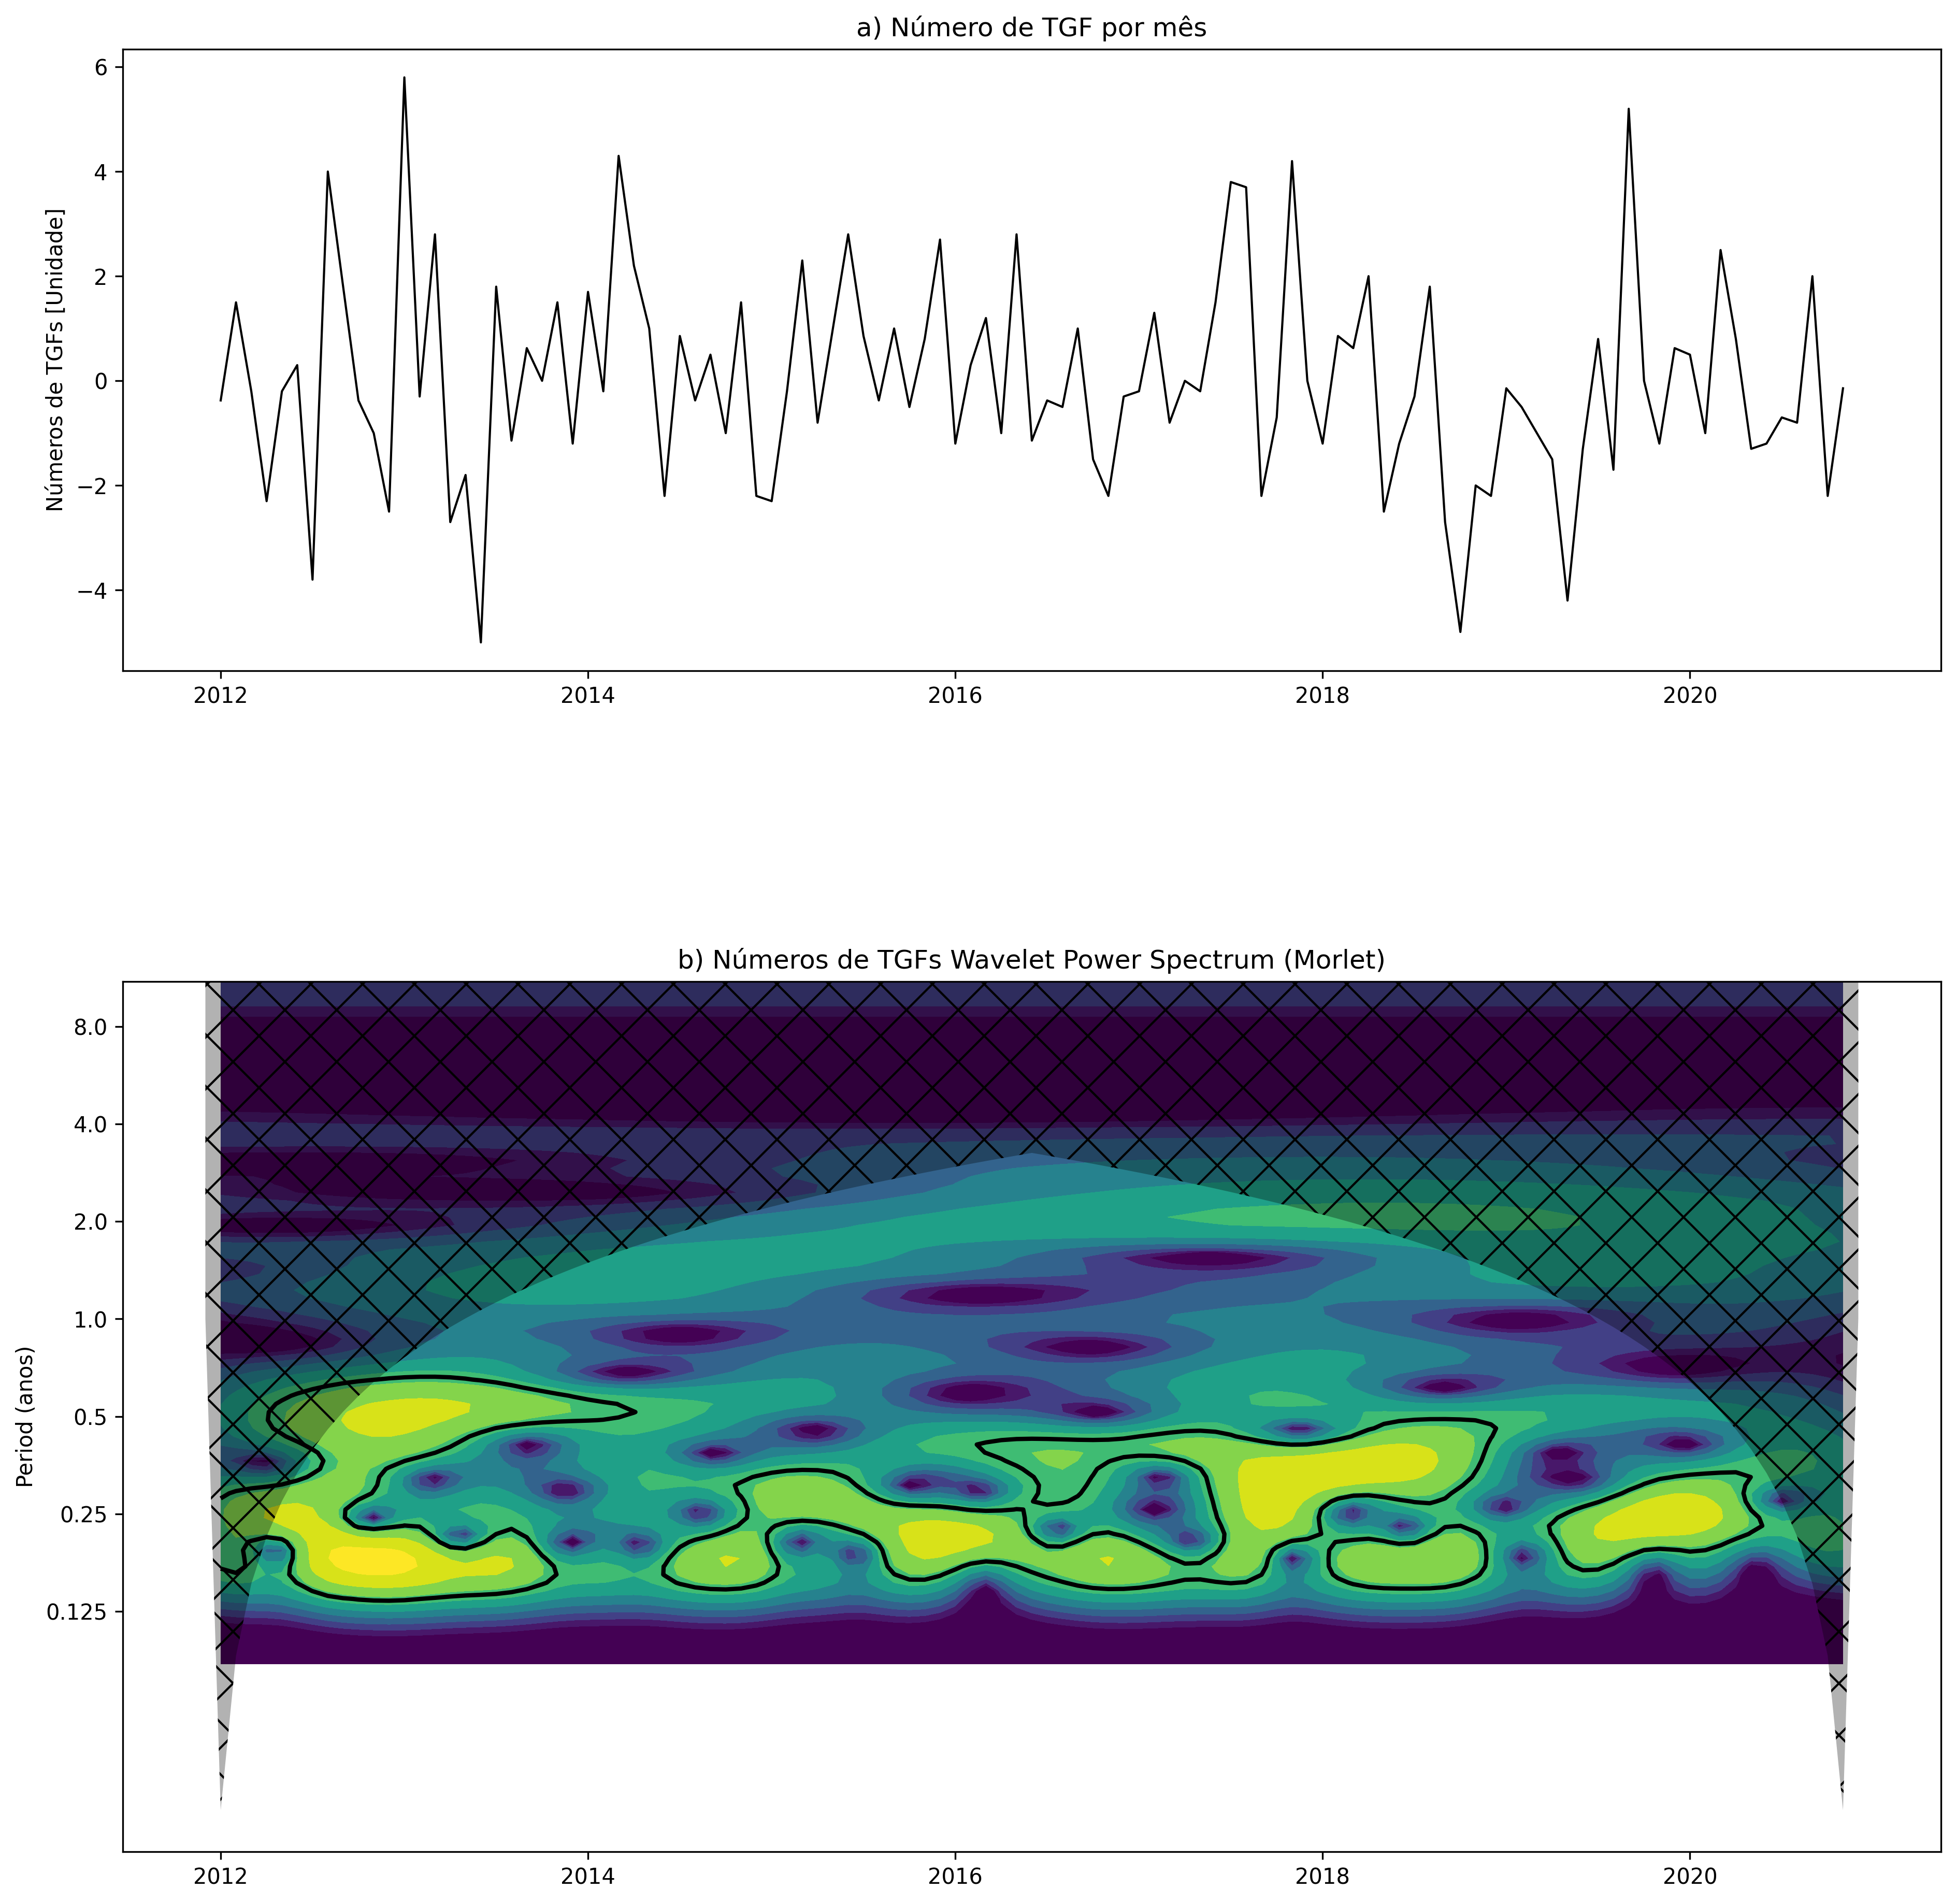

In [ ]:
#figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(18, 20), dpi=300)
fig = pyplot.figure(**figprops)

#original timeseries
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, anomalia, 'k', linewidth=1.)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

#normalized wavelet power spectrum
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (anos)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)


pyplot.show()